# Modelo Binomial - Derivativos

# Inputs

### Importar Pacotes

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

### Série Histórica do Ativo

In [2]:
inicio = "2020-12-31" # trocar
fim = pd.to_datetime("today") # data atual (retorna o dia de hoje, mas pode ser uma data qualquer)
ativo = "BBDC4.SA"

In [3]:
dados = yf.download(start = inicio, end = fim, tickers = ativo)
dados["retorno"] = dados["Adj Close"].pct_change()
dados.dropna(inplace = True)

[*********************100%***********************]  1 of 1 completed


### Características da Opção

In [4]:
nome = "BBDCB234" # alterar
r = 0.0915 # taxa livre de risco - alterar
#S = dados.iloc[len(dados)-1]["Adj Close"] # preço spot
S = 22.60
X = 23.17 # strike da opção - alterar
dt = 15 # dias úteis até o vencimento - alterar
C0 = 0.44 # preço atual da opção - alterar

# Calculando os retornos médios para cenários de alta e baixa

##### Opção 1: Média dos valores obtidos para os retornos de alta e baixa na série histórica

In [18]:
df = dados[["Adj Close", "retorno"]]
pd.options.mode.chained_assignment = None  # default='warn'

df["up"] = np.where(df["retorno"] >= 0, df["retorno"], 0) # retornos de alta
df["down"] = np.where(df["retorno"] < 0, df["retorno"], 0) # retornos de baixa

u = df[df["up"] != 0].mean()["up"] # média dos retornos de alta
d = df[df["down"] != 0].mean()["down"] # média dos retornos de baixa

##### Opção 2: Volatilidade média do ativo incorporada a cenários de alta e baixa

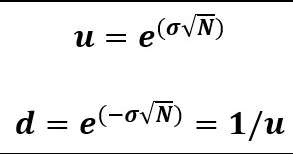

In [6]:
df = dados[["Adj Close", "retorno"]]
pd.options.mode.chained_assignment = None

s = df["retorno"].std()
u = np.exp(s)
d = 1/u
u = u - 1
d = d - 1

# Calcula as probabilidades de alta ou baixa

##### Cálculo 1: proporção de retornos de alta em relação a todas as observações

In [14]:
df["q"] = np.where(df["retorno"] >= 0, 1, 0) 
q = sum(df["q"])/len(df["q"]) 

##### Cálculo 2: probabilidade de Cox-Rubinstein
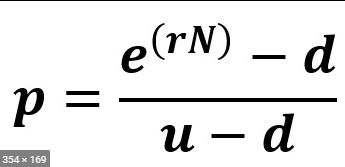

In [9]:
q = (np.exp(r/252*dt) - d) / (u - d)

# Probabilidades de cada um dos cenários finais possíveis

Cada cenário é uma sequência de altas (retorno = 1 + u) e baixas (retorno = 1 + d) com probabilidades de ocorrência q e 1-q, respectivamente.

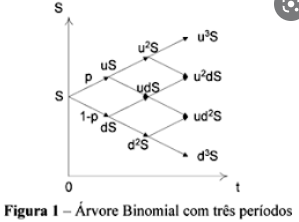

Os cenários do meio podem ser alcançados de n formas diferentes, sendo n equivalente ao seu valor no triângulo de Pascal (onde cada número é a soma dos 2 anteriores a ele, vide imagem)

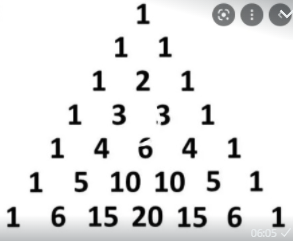

In [15]:
mults, probs = [], [] # valores dos nós finais da árvore, com suas probabilidades 
for i in range(dt+1):
    
    mult = ((1+u)**i)*((1+d)**(dt-i))
    mults.append(mult)
    
    prob = ((q)**i) * ((1-q) ** (dt-i))
    probs.append(prob)

# retorna as linhas do triangulo de pascal, só a última interessa
def tri_pascal(n): 
    linhas = [[1], [1,1]]
    for i in range(n-1):
        linha_ant = linhas[-1]

        linha_nova = [1]
        for j in range(i+1):
            num = linha_ant[j] + linha_ant[j+1]
            linha_nova.append(num)
        linha_nova.append(1)   

        linhas.append(linha_nova)
    return linhas

# multiplica a prob pelo valor da sua posição no triângulo de pascal
probabilidades = [probs[i] * tri_pascal(dt)[-1][i] for i in range(len(probs))] 

### Valor esperado para o preço da opção 

In [16]:
# Calculando os preços possíveis
precos = [i*S for i in mults]

# Preço final - strike
resultado_call = [X-i for i in precos]
resultado_put = [i-X for i in precos]

# Preço da call é igual ao resultado se ele for positivo
precos_calls = [i if i > 0 else 0 for i in resultado_call]
precos_puts = [i if i > 0 else 0 for i in resultado_put]

# média ponderada do preço esperado da call 
C = 0
for i in range(len(precos_calls)):
    C += precos_calls[i]*probabilidades[i]

P = 0
for i in range(len(precos_puts)):
    P += precos_puts[i]*probabilidades[i]

# descontando o preço pela taxa livre de risco
C = C * np.exp(-r*dt/252)
P = P * np.exp(-r*dt/252)

### Resultado

In [17]:
pd.DataFrame({"Variável" : ["Ticker da Opção",
                            "Preço Spot do Ativo",
                            "Strike da Opção",
                            "Dias-úteis até o vencimento",
                            "Taxa Livre de Risco",
                            "Preço Atual da Opção",
                            "Preço Alvo da Opção de Compra",
                            "Preço Alvo da Opção de Venda"],
                 "Valor" : [nome,
                            "R$ {:2.2f}".format(S),
                            "R$ {:2.2f}".format(X),
                            str(dt),
                            "{:.2%}".format(r),
                            "R$ {:5.2f}".format(C0),
                            "R$ {:5.2f}".format(C),
                            "R$ {:5.2f}".format(P)]})

,Variável,Valor
0,Ticker da Opção,BBDCB234
1,Preço Spot do Ativo,R$ 22.60
2,Strike da Opção,R$ 23.17
3,Dias-úteis até o vencimento,15
4,Taxa Livre de Risco,9.15%
5,Preço Atual da Opção,R$ 0.44
6,Preço Alvo da Opção de Compra,R$ 0.84
7,Preço Alvo da Opção de Venda,R$ 0.32
